# RTED-TDS Co-Sim

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted`` has attributes ``rted`` and ``dcopf``. The two attributes are the RTED model and standard DCOPF model.
The two model can be built by methods ``build_rted()`` and ``build_dcopf()``, respectively. The results can be accessed by method ``get_res()``, after successfully solved the ``rted`` or ``dcopf``.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, amtplotlib, scipy

## Import case

In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from jams import rted2, dcopf, rted3

In [2]:
from ev_ssm import ev_ssm

Package version

In [3]:
print(andes.__version__)
print(pp.__version__)

1.7.1.post224.dev0+g7b5a724f
2.8.0


EV aggregator

In [4]:
caseH = 10

In [5]:
sse = ev_ssm(ts=caseH, N=10000, step=1, tp=100,
             lr=0.1, lp=100, seed=2022, name="EVA")
sse.load_A("Aest.csv")

EVA: ts=10[H], 10000 EVs, Total Q=250.12 MWh
Online 1983, Q=49.73 MWh, SoC=0.9834
Power(MW): Pt=-0.3613, Pc=-0.3613, Pd=-0.0
Ctrl: 0=1921; 1=62; 
EVA: Load A from Aest.csv.


Import ADNES case

In [6]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes2"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1714 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0635 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0253 seconds.


Set output mode as 'manual'

In [7]:
ssa.TDS.config.save_mode = 'manual'

Set load as constant load.

In [8]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [9]:
ssa.config.numba

0

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

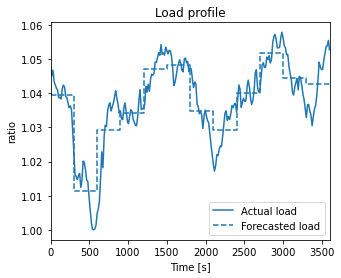

In [10]:
# --- get ANDES load ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale d_syn ---
ddata_path = '/case/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 30
# The equation is tuned for ieee39
# original: (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1
if caseH == 10:
    d_syn['s10'] = 1*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].var() + 1
if caseH == 18:
    d_syn['s10'] = 2*(d_syn['ha18'] - d_syn['ha18'].min()) / d_syn['ha18'].var() + 1

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [11]:
ev_idx = 'PV_10'

In [12]:
# --- set up EV generator data ---
ssa.PV.set(src='p0', idx=ev_idx, attr='v', value=sse.Ptc)
ssa.PV.set(src='pmax', idx=ev_idx, attr='v', value=sse.Pu)
ssa.PV.set(src='pmin', idx=ev_idx, attr='v', value=sse.Pl)

True

In [13]:
# --- conversion ---
ssp = to_pandapower(ssa)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, G1-11. G10 EV, G11 Slack
linearcost = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.5]

gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0041 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221392125e-09
Converged in 5 iterations in 0.0051 seconds.
Report saved to "ieee39_ev2_out.txt" in 0.0016 seconds.
Power flow results are consistent. Conversion is successful.


True

In [14]:
ssp.gen

,name,slack,bus,p_mw,vm_pu,controllable,in_service,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,slack_weight,scaling,sn_mva
0,PV_1,False,29,436.086385,1.035534,True,True,1500.0,200.0,183.816,-58.084,0.0,1,100
1,PV_2,False,30,645.999998,1.013246,True,True,900.0,150.0,515.7648,-122.665,0.0,1,100
2,PV_3,False,31,724.999998,1.020528,True,True,800.0,100.0,536.0664,-180.218,0.0,1,100
3,PV_4,False,32,651.999998,1.01343,True,True,700.0,100.0,657.8496,-213.78,0.0,1,100
4,PV_5,False,33,520.0,1.019109,True,True,700.0,100.0,733.794,-188.028,0.0,1,100
5,PV_6,False,34,690.0,1.06,True,True,800.0,100.0,712.5456,-234.972,0.0,1,100
6,PV_7,False,35,590.0,1.06,True,True,700.0,100.0,682.0464,-249.132,0.0,1,100
7,PV_8,False,36,330.0,1.013996,True,True,700.0,100.0,532.1616,-216.122,0.0,1,100
8,PV_9,False,37,780.0,1.052803,True,True,1000.0,100.0,1001.73,-356.889,0.0,1,100
9,PV_10,False,37,-36.128532,1.052803,False,True,1144.862135,-38.104337,0.0,0.0,0.0,1,100


Build RTED instance ``ssd``

In [15]:
ssd = rted2()
ssd.from_andes(ssa)

# set EV generator as uncontrollable
ssd.gen.ctrl.iloc[9] = 0

# set EV geenrator as type2
prumax = sse.g_frc()[0]
prdmax = sse.g_frc()[1]
ssd.def_type2([ev_idx], [prumax], [prdmax])

# set ramp5
ramp_hour = [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999]
# ramp_hour = [80, 80, 80, 50, 50, 50, 30, 30, 30, 999, 30]
ssd.gen.ramp5 = np.array(ramp_hour) * 10 / 12 / ssd.mva

# set cost
ssd.cost.c1 = linearcost

# set SFR cost of EV lower than SynGen
ssd.cost.cru = 0.1
ev_loc = ssd.cost[ssd.cost.idx == ev_idx].index[0]
ssd.cost.cru.iloc[ev_loc] = 0.0999
ssd.cost.crd = ssd.cost.cru

# update p_pre from DCOPF results
ssd.set_p_pre()

# sovle the model
ssd.get_res()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-08


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0035 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916599385
2: |F(x)| = 0.1314306449
3: |F(x)| = 0.000346374201
4: |F(x)| = 4.221392125e-09
Converged in 5 iterations in 0.0070 seconds.
Report saved to "ieee39_ev2_out.txt" in 0.0015 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xeef0a66e
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.
No RegUp requirement data (``du``), set to 0.
No RegDn requirement data (``dd``), set to 0.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x78d349e2
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [2e-02, 2e+03]
Presolve removed 117 rows and 33 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve RTED.


,gen,pg,pru,prd,bu,bd
0,PV_1,13.425285,0.0,0.0,0.0,0.0
1,PV_2,1.500000,0.0,0.0,0.0,0.0
2,PV_3,1.000000,0.0,0.0,0.0,0.0
3,PV_4,1.000000,0.0,0.0,0.0,0.0
4,PV_5,7.000000,0.0,0.0,0.0,0.0
5,PV_6,8.000000,0.0,0.0,0.0,0.0
6,PV_7,7.000000,0.0,0.0,0.0,0.0
7,PV_8,7.000000,0.0,0.0,0.0,0.0
8,PV_9,10.000000,0.0,0.0,0.0,0.0
9,PV_10,-0.361285,0.0,0.0,0.0,0.0


Benchmark Standard DCOPF of ``ssd`` with ``ssp``

In [16]:
pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ssdc = ssd.to_dcopf()
gb_res = ssdc.get_res()
ppres['p_mw(GB)'] = ssp.sn_mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")
ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xeef0a66e
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.


pp cost=6006.4000000333945, gb cost=60.064


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,415.961327,92.622757,8.821480,1.0,1192.528532
1,667.987081,311.488301,9.762500,1.0,900.000000
2,748.989037,149.407550,13.890681,1.0,100.000000
3,581.724808,131.140357,13.807915,1.0,100.000000
4,581.759853,146.559740,13.974152,1.0,100.000000
5,581.966213,227.749422,15.477922,1.0,800.000000
6,616.879330,63.219181,20.273456,1.0,700.000000
7,430.820754,-27.585564,11.229274,1.0,700.000000
8,966.440129,118.941642,22.442401,1.0,1000.000000
9,-36.128532,0.000000,22.442401,1.0,-36.128532


## Prepare

### Make link table

In [17]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


### Define functions used in loop

In [18]:
# --- def functions ---
def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    ratio = 60
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(load_ci[0] - load_exp) * ratio
    load_u = abs(load_ci[1] - load_exp) * ratio
    return load_u, load_d, load_exp

## Define param

In [19]:
# --- constants ---
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.1
ace_res = pd.DataFrame()

# initial load
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

Check if RTED converge in all 12 intervals

In [20]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(700):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed)
        ssp.load.scaling = load_exp
        ssd.load['p0'] = ssa_p0 * load_exp
        ssd.update_dict()

        # --- RTED, update gen limits after SFR ---
        if end_time > 0:
            # get pe from TDS and sort
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2,
                                  on='stg_idx', how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds
            ssd.gen.p_pre = pd.merge(left=ssd.gen, how='left', on='idx',
                                     right=pe_tds[['stg_idx', 'pe']].rename(columns={'stg_idx': 'idx'}))['pe']
        else:
            # DCOPF results as the initial previous setpoints
            ssd.set_p_pre()
            p_pre = ssd.gen[['idx', 'p_pre']].rename(columns={'p_pre': 'pe', 'idx': 'stg_idx'})

        # def sfr requirements and ev sfr limtis (p.u.)
        # Integrate EV; EV limits FROM EVA;
        [prumax, prdmax] = sse.g_frc()
        ssd.def_type2([ev_idx], [prumax*0.5], [prdmax*0.5])
        ssd.def_sfr(du=du*ssa_p0_sum, dd=dd*ssa_p0_sum)

        # build and solve the RTED-DC
        dcres = ssd.get_res()  # get RTED-DC resutls
        # TODO: Integrate EV; send SFR back to EV

        # Reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                           right=dcres.rename(columns={'gen': 'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        p_pre_pp = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=p_pre[['stg_idx', 'pe']],
                            on='stg_idx', how='left')['pe']
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) + np.array(ssd.gen.ramp5))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) - np.array(ssd.gen.ramp5))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr', 'max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr', 'min_ramp']].max(axis=1)

        # --- ACOPF, update setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # run ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True)  # Fill NA wil False

        # reset Generator limtis
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- AGC allocation, with a power cap ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        agc_res[f'{end_time}'] = agc_table['paux']
        ace_data = [end_time, ACE_raw, dcres.pru.sum(),
                    -1*dcres.prd.sum(), ACE_input]
        ace_new = pd.DataFrame([ace_data], columns=['time', 'ace', 'up', 'dn', 'in'])
        ace_res = pd.concat([ace_res, ace_new])

        # --- Do AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg['paux2'] = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG;
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg['paux2'] = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                   value=agc_dg.paux2.values)
        # TODO: c.EV;
        agc_ev = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_ev['paux2'] = agc_ev.paux * agc_ev.gammap
        sse_agc = agc_ev[agc_ev.stg_idx == ev_idx].paux2.values

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            if idx_agc == 0:
                # only record the pe from TDS in the first AGC interval
                copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ssp_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.1
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                               attr='v', value=ssp_res.pref[cond_gov].values)
            # update DG setpoints;
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                       attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    if end_time == 0:
        # Initially, alter StaticGen: p0 and q0, RUN power flow
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.StaticGen.set(src='v0', idx=stg_opf_idx, attr='v', value=stg_opf_v)
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * load_exp)
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * load_exp)
        ssa.PFlow.run()
    else:
        # Otherwise, alter Ppf and Qpf
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])
        # TODO: EV
        sse.run(tf=caseH+end_time/3600, Pi=sse_agc[0], is_update=False, is_record=False, disable=True)
        sse.report(is_report=False)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[ssp_res.stg_idx == ev_idx].values[0],
                   attr='v', value=sse.Ptc)

    # RUN TDS
    ssa.TDS.config.tf = end_time
    if end_time == 0:
        ssa.TDS.init()
    ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xce574cba
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [6e+01, 2e+03]
Presolve removed 69 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2376714e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.237671394e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xda0a8bb8
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e-01, 2e+00]
  Bounds range     [4e-01, 2e+01]
  RHS range        [1e-02, 2e+03]
Presolve removed 105 rows and 12 columns
Presolve time: 0.00s
Presolved: 12 rows, 21 columns, 41 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2748218e+01   1.887933e+01   0.000000e+00      0s
       7    6.2748403e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.274840265e+01


Successfully solve RTED.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0032 seconds.
0: |F(x)| = 7.715794203
1: |F(x)| = 3.595670773
2: |F(x)| = 0.1999849516
3: |F(x)| = 0.0008438316613
4: |F(x)| = 2.91200184e-08
Converged in 5 iterations in 0.0042 seconds.
Report saved to "ieee39_ev2_out.txt" in 0.0014 seconds.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for dynamics completed in 0.0378 seconds.
Initialization was successful.

-> Time Domain Simulation Summa

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=0.00 sec completed in 0.0010 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation to t=1.00 sec completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2.00 sec completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3.00 sec completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=4.00 sec completed in 0.0863 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=5.00 sec completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=6.00 sec completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=7.00 sec completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=8.00 sec completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=9.00 sec completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=10.00 sec completed in 0.0685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=11.00 sec completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=12.00 sec completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=13.00 sec completed in 0.0644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=14.00 sec completed in 0.0612 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=15.00 sec completed in 0.0551 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=16.00 sec completed in 0.0669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=17.00 sec completed in 0.0675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=18.00 sec completed in 0.0579 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=19.00 sec completed in 0.0558 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=20.00 sec completed in 0.0665 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=21.00 sec completed in 0.0507 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=22.00 sec completed in 0.0539 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=23.00 sec completed in 0.0546 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=24.00 sec completed in 0.0533 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=25.00 sec completed in 0.0508 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=26.00 sec completed in 0.0523 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=27.00 sec completed in 0.0632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=28.00 sec completed in 0.0517 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=29.00 sec completed in 0.0511 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=30.00 sec completed in 0.0534 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=31.00 sec completed in 0.0520 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=32.00 sec completed in 0.0493 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=33.00 sec completed in 0.0534 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=34.00 sec completed in 0.0517 seconds.


KeyboardInterrupt: 

In [ ]:
ssa.exit_code

In [ ]:
# ssa.TDS.save_output()

In [ ]:
# color=['tab:blue', 'tab:orange', 'tab:green',
#        'tab:red', 'tab:purple']
right = end_time

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.3)

yheader = [f'G{i}' for i in range(1, 11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                 yheader=yheader,
                 legend=True, show=False, right=right,
                 title=r'Generation (solid: pout; dash: pref)',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                 linestyles=['--'],
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader,
                 legend=False, show=False, right=right,
                 title=r'AGC power',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[0, 1])

# Plot EV AGC response, hard code
ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prl, color='tab:orange', linestyle=':')
ax_gen[0, 1].plot(3600*(np.array(sse.tss)-10), sse.Prcl, color='tab:orange', linestyle='-')
ax_gen[0, 1].set_ylim(top=max(sse.Prl) * 1.2)

ace_res.plot(linewidth=1,
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='ace',
             title=f'AGC input and SFR capacity')
ace_res.plot(linewidth=1,
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='in',)
ace_res.plot(linewidth=1, color='k', linestyle='--',
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='up')
ace_res.plot(linewidth=1, color='k', linestyle='--',
             fig=fig_gen, ax=ax_gen[0, 2],
             x='time', y='dn')
ax_gen[0, 2].set_ylabel('p.u.')
ax_gen[0, 2].legend(['ACE raw', 'AGC input', 'SFR capacity'])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE Density, mean={ace_df.ace.mean().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [p.u.]', ylabel='')

In [ ]:
fige, axe = plt.subplots()
axe.plot(3600*(np.array(sse.tss)-10), sse.Prl, color='tab:orange', linestyle=':', label='Signal')
axe.plot(3600*(np.array(sse.tss)-10), sse.Prcl, color='tab:orange', linestyle='-', label='Response')
axe.grid()
axe.legend()
axe.set_xlim(3600*(sse.tss[0]-10), 3600*(sse.tss[-1]-10))
axe.set_ylabel('p.u.')
axe.set_xlabel('Time [s]')

In [ ]:
sse.report()

In [ ]:
sse.plot()